# Dealing with Low Confidence Situations

First we analyze a few scenarios where spurious examines or clicks result in inaccurate relevance grades. We then augment the SDBN judgments with a beta prior to better model the amount of confidence we have in the underlying click data.

In [1]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
from session_gen import SessionGenerator
import os
from IPython.core.display import display,HTML

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


In [3]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('data/*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,50002,blue ray,0.0,600603141003,True
1,50002,blue ray,1.0,827396513927,False
2,50002,blue ray,2.0,24543672067,False
3,50002,blue ray,3.0,719192580374,False
4,50002,blue ray,4.0,885170033412,True
...,...,...,...,...,...
74995,5001,transformers dark of the moon,10.0,47875841369,False
74996,5001,transformers dark of the moon,11.0,97363560449,False
74997,5001,transformers dark of the moon,12.0,93624956037,False
74998,5001,transformers dark of the moon,13.0,97363532149,False


In [4]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())

products

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",883929153121,Clash Of The Titans Iphone Skin Presell - DVD,\N,\N,\N,037a0d2b-c2c0-47c4-9a1e-1b3d36a69619,1697945072192978961
1,"<img height=""100"" src=""../data/retrotech/image...",885909343874,Apple&#xAE; - iPhone 4 with 16GB Memory - Blac...,Apple&#xAE;,"Up to 7 hours talk time3.5"" Retina color displ...","This slim, powerful iPhone features a high-qua...",f316dcad-098f-4c32-b5da-38bac1fb5cb8,1697945072211853323
2,"<img height=""100"" src=""../data/retrotech/image...",36725235564,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",Samsung,\N,"Enjoy video games, movies and more with this S...",4421ed7b-367b-44a2-b4b9-5236f6558f0d,1697945072260087828
3,"<img height=""100"" src=""../data/retrotech/image...",22265004258,"Toshiba - 32"" Class - LCD - 720p - 60Hz - HDTV",Toshiba,\N,"This 32"" LCD HDTV supports stunning images up ...",c3eed625-faa9-4ab1-9f24-0fb0bf93fabc,1697945072275816486
4,"<img height=""100"" src=""../data/retrotech/image...",719192579996,"LG - 47"" Class - LCD - 1080p - 120Hz - HDTV",LG,ENERGY STAR Qualified,Enjoy your favorite movies and more with this ...,1c8f3c05-b4cd-49a8-9ddf-181411ed34fc,1697945072277913630
...,...,...,...,...,...,...,...,...
306,"<img height=""100"" src=""../data/retrotech/image...",97361455044,Thor (2011) (2 Disc) (W/Dvd) - Widescreen Dubb...,\N,\N,\N,fcbc849b-a575-4921-9fb5-767e847fa5f7,1697945073376821262
307,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,4ab55b45-5276-4d97-a949-6b0d392eea02,1697945073381015574
308,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates Of The Caribbean: On Stranger Tides (3...,\N,\N,\N,63c82705-4e45-4660-a9ff-c28e39e19c23,1697945073381015578
309,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates of the Caribbean: On Stranger Tides - ...,\N,\N,\N,7899bfdb-56ea-4c70-9394-193cf0b52777,1697945073784717322


## Listing 11.10

Computing SDBN judgments on transformers dark of the moon

In [5]:
QUERY='transformers dark of the moon'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)
sdbn

,clicked,examined,grade
doc_id,,,
97360810042,412.0,642.0,0.641745
400192926087,62.0,129.0,0.480620
97363560449,96.0,243.0,0.395062
97363532149,42.0,130.0,0.323077
93624956037,41.0,154.0,0.266234
47875842328,367.0,1531.0,0.239713
47875841420,217.0,960.0,0.226042
25192107191,176.0,1082.0,0.162662
786936817218,118.0,777.0,0.151866


## Listing 11.11

Computing relevance judgments for `blue ray` a simulated tail query that represents a misspelling with sparse data.

In [6]:
QUERY='blue ray'
# Simulate a rare query by slicing out some data
sdbn_sessions = sessions[sessions['query'] == QUERY]
sdbn_sessions = sdbn_sessions[sdbn_sessions['sess_id'] < 50050]
sdbn_sessions = sdbn_sessions.set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)
sdbn

,clicked,examined,grade
doc_id,,,
600603132872,1.0,1.0,1.000000
827396513927,14.0,34.0,0.411765
25192073007,8.0,20.0,0.400000
885170033412,6.0,19.0,0.315789
600603141003,8.0,26.0,0.307692
24543672067,8.0,27.0,0.296296
813774010904,2.0,7.0,0.285714
883929140855,2.0,7.0,0.285714
22265052211,1.0,4.0,0.250000


# Figure 11.9

Beta distribution for grade=0.125

a=2.5 b=17.5


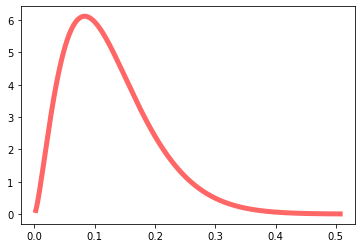

In [7]:
from scipy.stats import beta

prior_grade = 0.125

prior_weight = 20
a=prior_grade*prior_weight; b=(1-prior_grade)*prior_weight
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 11.10

Adding clicks to the beta distribution

a=3.5 b=17.5


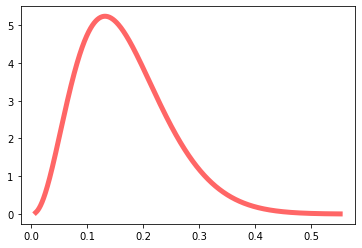

In [8]:
# Fit a beta prior to global_ctr
a+=1
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

## Listing 11.12

Starting with a prior beta distribution for each document for "blue ray"

In [9]:
PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn

,clicked,examined,grade,prior_a,prior_b
doc_id,,,,,
600603132872,1.0,1.0,1.000000,30.0,70.0
827396513927,14.0,34.0,0.411765,30.0,70.0
25192073007,8.0,20.0,0.400000,30.0,70.0
885170033412,6.0,19.0,0.315789,30.0,70.0
600603141003,8.0,26.0,0.307692,30.0,70.0
24543672067,8.0,27.0,0.296296,30.0,70.0
813774010904,2.0,7.0,0.285714,30.0,70.0
883929140855,2.0,7.0,0.285714,30.0,70.0
22265052211,1.0,4.0,0.250000,30.0,70.0


## Listing 11.13

Here we update the beta posterior to account for the observations in our data. We then compute a new grade, `beta-grade` from the posterior distribution.

In [10]:
sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
827396513927,14.0,34.0,0.411765,30.0,70.0,44.0,90.0,0.328358
25192073007,8.0,20.0,0.400000,30.0,70.0,38.0,82.0,0.316667
600603132872,1.0,1.0,1.000000,30.0,70.0,31.0,70.0,0.306931
885170033412,6.0,19.0,0.315789,30.0,70.0,36.0,83.0,0.302521
600603141003,8.0,26.0,0.307692,30.0,70.0,38.0,88.0,0.301587
24543672067,8.0,27.0,0.296296,30.0,70.0,38.0,89.0,0.299213
813774010904,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
883929140855,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
22265052211,1.0,4.0,0.250000,30.0,70.0,31.0,73.0,0.298077


In [11]:
sdbn = sdbn.sort_values('beta_grade', ascending=False).reset_index()
sdbn

,doc_id,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
0,827396513927,14.0,34.0,0.411765,30.0,70.0,44.0,90.0,0.328358
1,25192073007,8.0,20.0,0.400000,30.0,70.0,38.0,82.0,0.316667
2,600603132872,1.0,1.0,1.000000,30.0,70.0,31.0,70.0,0.306931
3,885170033412,6.0,19.0,0.315789,30.0,70.0,36.0,83.0,0.302521
4,600603141003,8.0,26.0,0.307692,30.0,70.0,38.0,88.0,0.301587
5,24543672067,8.0,27.0,0.296296,30.0,70.0,38.0,89.0,0.299213
6,813774010904,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
7,883929140855,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
8,22265052211,1.0,4.0,0.250000,30.0,70.0,31.0,73.0,0.298077
9,786936817232,2.0,8.0,0.250000,30.0,70.0,32.0,76.0,0.296296


In [12]:
render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.328358,,8.273965e+11,Panasonic - Refurbished Wi-Fi Ready Blu-ray Disc Player,RefurbishedPlays DVD and Blu-ray Discs; 1080p upconversion; 2-channel analog output104.99
1,0.316667,,2.519207e+10,The Blues Brothers - Widescreen Dubbed Subtitle - Blu-ray Disc,\N
2,0.316667,,2.519207e+10,Blues Brothers (Rated) (Unrated) - Widescreen Dubbed Subtitle - Blu-ray Disc,\N
3,0.306931,NaN,NaN,NaN,NaN
4,0.302521,,8.851700e+11,Panasonic - Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray Discs; HDMI output; analog audio outLearn more about smart products.
5,0.301587,NaN,NaN,NaN,NaN
6,0.299213,,2.454367e+10,Predators - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
7,0.299065,,8.137740e+11,Samsung - Refurbished Wi-Fi Ready Blu-ray Player with HDMI Cable,RefurbishedENERGY STAR QualifiedPlays DVD and Blu-ray Discs; 1080p video output; 2-channel audio outputLearn more about smart products.
8,0.299065,,8.839291e+11,Green Lantern - Blu-ray Disc,\N
9,0.298077,,2.226505e+10,Toshiba - Wi-Fi Ready Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray; 1080p HD video output;Learn more about smart products.


In [13]:
products[products['upc'] == 25192073007]

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
294,"<img height=""100"" src=""../data/retrotech/image...",25192073007,The Blues Brothers - Widescreen Dubbed Subtitl...,\N,\N,\N,d76fd0b0-a585-4bf0-913d-17272dcd25e1,1697945072942710784
301,"<img height=""100"" src=""../data/retrotech/image...",25192073007,Blues Brothers (Rated) (Unrated) - Widescreen ...,\N,\N,\N,e7d11a74-fd6a-492d-ba64-c7db8ff57aa4,1697945072834707472


# Figure 11.10 source code

Rendering beta distribution updated judgments to model our confidence in them

In [14]:
QUERY='transformers dark of the moon'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)

PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.595687,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
1,0.401747,,400192926087,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
2,0.367347,,97363560449,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
3,0.313043,,97363532149,Transformers: Revenge of the Fallen - Widescreen Dubbed Subtitle - DVD,\N
4,0.279528,,93624956037,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
5,0.243409,,47875842328,Transformers: Dark of the Moon Stealth Force Edition - Nintendo Wii,Transform into an epic hero or a vehicular villain
6,0.233019,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
7,0.174281,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N
8,0.168757,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
9,0.168757,,786936817218,Pirates of the Caribbean: On Stranger Tides - Blu-ray 3D,\N


# Figure 11.11 source code

Rendering beta distribution updated judgments to model our confidence in them

In [26]:
QUERY='dryer'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)

PRIOR_GRADE=0.0
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.314421,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
1,0.317400,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
2,0.304430,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
3,0.257426,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
4,0.249534,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
5,0.225303,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package
6,0.232026,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
7,0.208333,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"
8,0.196324,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
9,0.177083,,36725561977,Samsung - 3.5 Cu. Ft. 6-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedSoft dial touch pad controls; 6 cycles; delay-start; child lock; Vibration Reduction Technology
